In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from os.path import join

import tensorflow as tf
import keras
from keras import layers, models, optimizers
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# MNIST data 불러오기
datax = np.load(join('data','MNIST.npy'))
datay = np.load(join('data','Label.npy'))

In [3]:
# normalize inputs from 0-255 to 0-1
# 흑백 이미지 데이터는 픽셀 하나당 0-255까지의 숫자값을 가지므로 이를 255로 나누면 0-1 사이로 normalize
datax_norm = datax/255
print('최대 : {}, 최소 : {}'.format(np.max(datax_norm), np.min(datax_norm)))

최대 : 1.0, 최소 : 0.0


In [4]:
# one hot encode outputs
datay_onehot = to_categorical(datay)
print(datay[0:10])
print(datay_onehot[0:10,:])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [5]:
# Sklearn의 train_test_split 함수를 써서 train/test data 분할
from sklearn.model_selection import train_test_split

# arrays에 데이터와 레이블을 둘 다 넣었기 때문에 train,test 데이터셋이 분할되어 반환됨.(7:3)
# random_state: 데이터 분할시 셔플이 이루어지는데 이를 위한 시드값(int나 RandomState로 입력)
trnx, tstx, trny, tsty = train_test_split(datax_norm, datay_onehot, test_size=0.3, random_state=111)
print(trnx.shape) # (데이터개수, x픽셀, y픽셀)
print(tstx.shape)
print(trny.shape)
print(trnx[0].shape)

(42000, 28, 28)
(18000, 28, 28)
(42000, 10)
(28, 28)


In [6]:
# (데이터수, x픽셀, y픽셀, 채널수) 형태로 데이터를 맞춰줌. (CNN은 multi-channel을 가정하기 때문)
trnx_reshape = trnx.reshape(-1,28,28,1)
tstx_reshape = tstx.reshape(-1,28,28,1)
print(trnx_reshape.shape)
print(tstx_reshape.shape)

(42000, 28, 28, 1)
(18000, 28, 28, 1)


In [7]:
# 모델 정의
input_shape = (28,28,1)

input_tensor = layers.Input(shape = input_shape)

conv1_1 = layers.Conv2D(8, (3,3), padding='same')(input_tensor)
conv1_2 = layers.BatchNormalization()(conv1_1)
conv1_3 = layers.Activation("relu")(conv1_2)
conv1_4 = layers.MaxPooling2D((3,3))(conv1_3)

conv2_1 = layers.Conv2D(16, (3,3), padding='same')(conv1_4)
conv2_2 = layers.BatchNormalization()(conv2_1)
conv2_3 = layers.Activation("relu")(conv2_2)
conv2_4 = layers.MaxPooling2D((3,3))(conv2_3)

conv3_1 = layers.Conv2D(32, (3,3), padding='same')(conv2_4)
conv3_2 = layers.BatchNormalization()(conv3_1)
conv3_3 = layers.Activation("relu")(conv3_2)
conv3_4 = layers.Dropout(0.5)(conv3_3)
conv3_5 = layers.MaxPooling2D((3,3))(conv3_4)

conv4_1 = layers.Conv2D(64, (3,3), padding='same')(conv3_5)
conv4_2 = layers.BatchNormalization()(conv4_1)
conv4_3 = layers.Activation("relu")(conv4_2)
conv4_4 = layers.Dropout(0.5)(conv4_3)

flatted = layers.Flatten()(conv4_4) # MLP로 classification하기 위해 flatten을 통해 1D vector 형태로 펴줌.

dense1 = layers.Dense(128, activation="relu")(flatted)
dense2 = layers.Dense(64, activation="relu")(dense1)
dense3 = layers.Dense(32, activation="relu")(dense2)
output_class = layers.Dense(10, activation="softmax")(dense3)

cnn_fmodel = models.Model(input_tensor, output_class)
cnn_fmodel.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [8]:
cnn_fmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 16)          1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 16)          64        
__________

In [9]:
history = cnn_fmodel.fit(trnx_reshape, trny, validation_data = [tstx_reshape, tsty], batch_size=512, epochs=50)

Train on 42000 samples, validate on 18000 samples
Epoch 1/50
42000/42000 [==============================] - 69s 2ms/step - loss: 1.6584 - acc: 0.3848 - val_loss: 0.8924 - val_acc: 0.7359
Epoch 2/50
42000/42000 [==============================] - 66s 2ms/step - loss: 0.8710 - acc: 0.6949 - val_loss: 1.1306 - val_acc: 0.5972
Epoch 3/50
42000/42000 [==============================] - 76s 2ms/step - loss: 0.5409 - acc: 0.8280 - val_loss: 1.2388 - val_acc: 0.6155
Epoch 4/50
42000/42000 [==============================] - 73s 2ms/step - loss: 0.4017 - acc: 0.8782 - val_loss: 0.5227 - val_acc: 0.8214
Epoch 5/50
42000/42000 [==============================] - 73s 2ms/step - loss: 0.3430 - acc: 0.8992 - val_loss: 0.5613 - val_acc: 0.7958
Epoch 6/50
42000/42000 [==============================] - 66s 2ms/step - loss: 0.2955 - acc: 0.9104 - val_loss: 0.4779 - val_acc: 0.8320
Epoch 7/50
42000/42000 [==============================] - 64s 2ms/step - loss: 0.2712 - acc: 0.9194 - val_loss: 0.5401 - val_acc

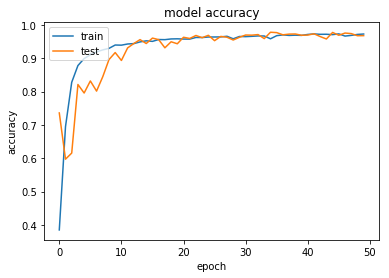

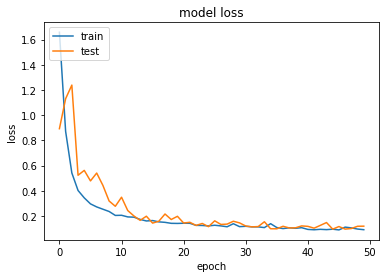

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# 정확도(성능) test
accuracy = history.history['val_acc'][-1]
print("[accuracy]: ", accuracy)

[accuracy]:  0.9679999998940362
